In [67]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path 
import cv2
import matplotlib.pyplot as plt 
import seaborn as sns
import torch
import torch.nn as nn

# EDA

In [68]:
image_dir = Path('../input/age-prediction/20-50/20-50') #tell python in which directory the training images are.
# filepaths = pd.Series(list(image_dir.glob(r'**/*.jpg')), name='Filepath').astype(str)
# ages = pd.Series(filepaths.apply(lambda x: os.path.split(os.path.split(x)[0])[1]), name='Age').astype(np.int)
# images = pd.concat([filepaths, ages], axis=1).sample(frac=1.0, random_state=1).reset_index(drop=True)
# images.head()

In [69]:
def preprocessing(image_dir):
    filepaths = pd.Series(list(image_dir.glob(r'**/*.jpg')), name='Filepath').astype(str)
    ages = filepaths.apply(lambda x: os.path.split(os.path.split(x)[0])[1]).astype(np.int16) # 파일경로에서 나이 추출

    ranged_ages = []
    for age in ages:
        if 20 <= age <= 24:
            ranged_ages.append('20-24')
        elif 25 <= age <= 29:
            ranged_ages.append('25-29')
        elif 30 <= age <= 34:
            ranged_ages.append('30-34')
        elif 35 <= age <= 39:
            ranged_ages.append('35-39')
        elif 40 <= age <= 44:
            ranged_ages.append('40-44')
        elif 45 <= age <= 50:
            ranged_ages.append('45-50')

    s_ages = pd.Series(ranged_ages, name='Age').astype(str)
    images = pd.concat([filepaths, s_ages], axis=1).sample(frac=1).reset_index(drop=True)
    
    return images

In [70]:
images = preprocessing(image_dir)
images.head()

,Filepath,Age
0,../input/age-prediction/20-50/20-50/train/45/1...,45-50
1,../input/age-prediction/20-50/20-50/train/38/1...,35-39
2,../input/age-prediction/20-50/20-50/train/20/1...,20-24
3,../input/age-prediction/20-50/20-50/train/40/1...,40-44
4,../input/age-prediction/20-50/20-50/train/39/1...,35-39


In [71]:
from sklearn.preprocessing import LabelEncoder
# LabelEncoder 객체 생성
label_encoder = LabelEncoder()

# train 데이터프레임의 'Age' 열을 라벨 인코딩
images['Age_encoded'] = label_encoder.fit_transform(images['Age'])
images

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


,Filepath,Age,Age_encoded
0,../input/age-prediction/20-50/20-50/train/45/1...,45-50,5
1,../input/age-prediction/20-50/20-50/train/38/1...,35-39,3
2,../input/age-prediction/20-50/20-50/train/20/1...,20-24,0
3,../input/age-prediction/20-50/20-50/train/40/1...,40-44,4
4,../input/age-prediction/20-50/20-50/train/39/1...,35-39,3
...,...,...,...
40435,../input/age-prediction/20-50/20-50/test/41/39...,40-44,4
40436,../input/age-prediction/20-50/20-50/test/34/38...,30-34,2
40437,../input/age-prediction/20-50/20-50/train/25/1...,25-29,1
40438,../input/age-prediction/20-50/20-50/train/28/1...,25-29,1


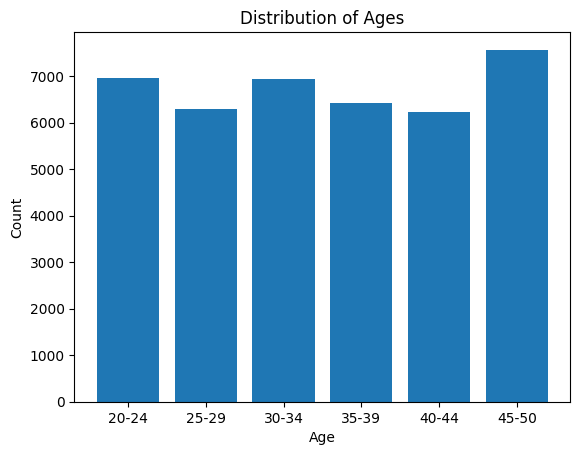

In [72]:
# 나이에 대한 빈도수 계산
age_counts = images['Age'].value_counts().sort_index()

# 막대그래프로 시각화
plt.bar(age_counts.index, age_counts.values)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Distribution of Ages')
plt.show()

Age: 20-24


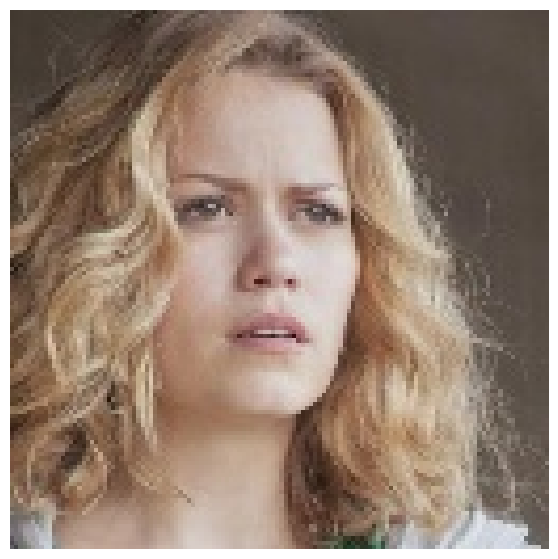

In [73]:
def visualize(image):
    plt.figure(figsize=(7, 7))
    plt.axis('off')
    plt.imshow(image)

#choose an image id to see its age
image_id = 35
image_example_path = images.iloc[image_id].Filepath
age = images.iloc[image_id].Age

print(f'Age: {age}')
image = cv2.imread(image_example_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
visualize(image)

# Prepare Data

In [75]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(images, test_size = 0.1, random_state = 1)
train, valid = train_test_split(train, test_size = 0.2, random_state = 1)

## Dataset class

In [76]:
from torch.utils.data import Dataset
from torchvision import transforms
import torch
import cv2
import numpy as np

class ImageAgeDataset(Dataset):
    def __init__(self, images, transform=None):
        self.age = images.Age_encoded.values
        self.paths = images.Filepath.values
        self.transform = transform

    def __len__(self):
        return len(self.age)

    def __getitem__(self, item):
        out = dict()
        path = self.paths[item]
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image)

        out['x'] = torch.tensor(image , dtype = torch.float).permute(2,0,1)/255 
        out['y'] = torch.tensor(self.age[item], dtype=torch.long)
        return out

# 이미지 데이터를 위한 변환 정의
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

In [77]:
train_dataset = ImageAgeDataset(train) 
valid_dataset = ImageAgeDataset(valid)

In [78]:
train_dataset[0]['x'].shape

torch.Size([3, 128, 128])

# Model

In [79]:
import torch
import torch.nn as nn
from torch import Tensor


In [89]:
import torch.nn as nn
import torch
import torch.nn.functional as F


class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        return x
    
class Inception(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj):
        super(Inception, self).__init__()

        self.branch1 = BasicConv2d(in_channels, ch1x1, kernel_size=1)

        self.branch2 = nn.Sequential(
            BasicConv2d(in_channels, ch3x3red, kernel_size=1),
            BasicConv2d(ch3x3red, ch3x3, kernel_size=3, padding=1)   # 保证输出大小等于输入大小
        )

        self.branch3 = nn.Sequential(
            BasicConv2d(in_channels, ch5x5red, kernel_size=1),
            BasicConv2d(ch5x5red, ch5x5, kernel_size=5, padding=2)   # 保证输出大小等于输入大小
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            BasicConv2d(in_channels, pool_proj, kernel_size=1)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)

        outputs = [branch1, branch2, branch3, branch4]
        return torch.cat(outputs, 1)
    
    
class InceptionAux(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(InceptionAux, self).__init__()
        self.averagePool = nn.AvgPool2d(kernel_size=5, stride=3)
        self.conv = BasicConv2d(in_channels, 128, kernel_size=1)  # output[batch, 128, 4, 4]

        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):

        x = self.averagePool(x)
        x = self.conv(x)
        x = torch.flatten(x, 1)
        x = F.dropout(x, 0.5, training=self.training)
        x = F.relu(self.fc1(x), inplace=True)
        x = F.dropout(x, 0.5, training=self.training)
        x = self.fc2(x)
        return x
    
    
class GoogLeNet(nn.Module):
    def __init__(self, num_classes=1000, aux_logits=True, init_weights=False):
        super(GoogLeNet, self).__init__()
        self.aux_logits = aux_logits

        self.conv1 = BasicConv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.maxpool1 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.conv2 = BasicConv2d(64, 64, kernel_size=1)
        self.conv3 = BasicConv2d(64, 192, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.inception3a = Inception(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = Inception(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.inception4a = Inception(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = Inception(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = Inception(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = Inception(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = Inception(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.inception5a = Inception(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = Inception(832, 384, 192, 384, 48, 128, 128)

        if self.aux_logits:
            self.aux1 = InceptionAux(512, num_classes)
            self.aux2 = InceptionAux(528, num_classes)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, num_classes)
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.maxpool2(x)

        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)
        x = self.inception4a(x)
        if self.training and self.aux_logits:    # eval model lose this layer
            aux1 = self.aux1(x)

        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        if self.training and self.aux_logits:    # eval model lose this layer
            aux2 = self.aux2(x)

        x = self.inception4e(x)
        x = self.maxpool4(x)
        x = self.inception5a(x)
        x = self.inception5b(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        if self.training and self.aux_logits:   # eval model lose this layer
            return x, aux2, aux1
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

# Engine

In [98]:
#hparams
DEVICE = 'cuda' 
BATCH_SIZE = 50
MAX_WAIT = 3
EPOCHS = 100
LR = 1e-2

#---------------------
train_dataloader = torch.utils.data.DataLoader(
    dataset = train_dataset,
    batch_size = BATCH_SIZE, 
    shuffle = True ,
    num_workers = 8
)

valid_dataloader = torch.utils.data.DataLoader(
    dataset = valid_dataset,
    batch_size = BATCH_SIZE, 
    shuffle = False,
    num_workers = 8
)
#---------------------
model = GoogLeNet(num_classes=6, aux_logits=True, init_weights=True)
model.to(DEVICE)
#---------------------
loss_fn = nn.CrossEntropyLoss()
#---------------------
optimizer = torch.optim.Adam(params = model.parameters(), lr = LR)
#---------------------
from tqdm.notebook import tqdm 
import numpy as np 
def train_step(model , optimizer , dataloader): 
  model.train()
  total_loss = 0 
  for data in tqdm(dataloader): 
    x = data["x"].to(DEVICE)
    y = data["y"].to(DEVICE)
    y_hat, _, _ = model(x)
    y_hat = y_hat.to(DEVICE)
#     y_hat = model(x).to(DEVICE) #to apply model(x), x and model must be in the same place (device)
    loss = loss_fn(y_hat , y) #enough for y_hat and y to be in the same device
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    total_loss += loss.item()
  #total_loss.backward()
  #optimizer.step()
  #optimizer.zero_grad()
  return total_loss/len(dataloader)

def valid_step(model, dataloader): 
  model.eval()
  total_loss = 0 
  for data in tqdm(dataloader): 
    x = data["x"].to(DEVICE)
    y = data["y"].to(DEVICE)
    with torch.no_grad():
      y_hat = model(x).to(DEVICE)
      loss = loss_fn(y_hat , y) 
    total_loss += loss.item()
  return total_loss/len(dataloader)

def main(model , optimizer , train_dataloader , valid_dataloader ): 
  train_losses = []
  valid_losses = [] 
  min_valid_loss = np.inf 
  patience = 0 
  for epoch in range(EPOCHS): 
    train_loss = train_step(model , optimizer , train_dataloader)
    train_losses.append(train_loss)  
    valid_loss = valid_step(model , valid_dataloader)
    valid_losses.append(valid_loss)
    print(f'EPOCH = {epoch}')
    print(f'train_loss = {train_loss}')
    print(f'valid_loss = {valid_loss}')
    if valid_loss > min_valid_loss : 
      patience += 1 
    else: 
      min_valid_loss = valid_loss 
      patience = 0 

    if patience > MAX_WAIT : 
      print(f'EARLY STOPPING AT EPOCH = {epoch}')
      break 
  return train_losses , valid_losses 
        

In [99]:
train_losses, valid_losses = main(
    model = model, 
    optimizer = optimizer, 
    train_dataloader = train_dataloader,
    valid_dataloader = valid_dataloader
)

  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 0
train_loss = 7713.844166051053
valid_loss = 1.7894221299315152


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 1
train_loss = 1.7903255391897919
valid_loss = 1.790107692757698


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 2
train_loss = 1.7903078023606263
valid_loss = 1.7883340397926226


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 3
train_loss = 1.7900217740858808
valid_loss = 1.7891724125979698


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 4
train_loss = 1.7904903772151286
valid_loss = 1.7894923793126458


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 5
train_loss = 1.790474686778021
valid_loss = 1.7892359421677786


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 6
train_loss = 1.7904724727159504
valid_loss = 1.7891430577186689
EARLY STOPPING AT EPOCH = 6


In [100]:
test_dataset = ImageAgeDataset(test)

In [101]:
len(test_dataset)

4044

In [102]:
age_labels = {'20-24' : 0, '25-29' : 1, '30-34' : 2, '35-39' : 3, '40-44' : 4, '45-50': 5}
inverse_age_labels = {v: k for k, v in age_labels.items()}


image 11 is 20-24 years old and is predicted 45-50 years old


/tmp/ipykernel_237/2595296351.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat_id = softmax(y_hat)


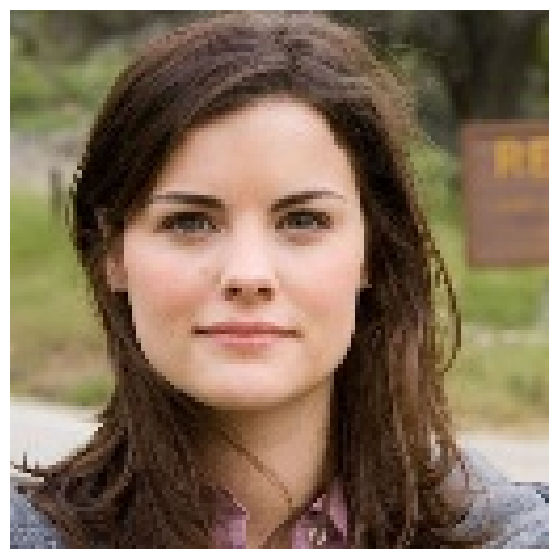

In [109]:
#play around.. choose an id from 0 to 4043 to test the model on :)
id = 11
softmax = nn.Softmax()
input_data = test_dataset[id]['x'].unsqueeze(0).to(DEVICE)
y_hat  = model(input_data)
y_hat_id = softmax(y_hat) 
# y_hat_id = softmax(model(test_dataset[id]['x'].to(DEVICE)))
def pred(x):
    for i in range(len(x[0])):
        if (x[0][i] == torch.max(x[0]).item()): 
            return i
true_age = train_dataset[id]['y'].item()
true_age = inverse_age_labels.get(true_age, None)
print(f'image {id} is {true_age} years old and is predicted {inverse_age_labels.get(pred(y_hat_id), None)} years old')
image = cv2.imread(test.iloc[id].Filepath)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
visualize(image)

In [111]:
from sklearn.metrics import accuracy_score

# 예측을 저장할 리스트
predictions = []

# 실제 레이블을 저장할 리스트
true_labels = []

# 모델을 평가할 데이터셋 선택 (여기서는 test_dataset을 사용)
eval_dataset = test_dataset

# 평가 데이터셋에 대해 예측 수행
for i in range(len(eval_dataset)):
    x = eval_dataset[i]['x'].unsqueeze(0).to(DEVICE)  # 배치 차원 추가
    y = eval_dataset[i]['y'].item()  # 정수 형태의 라벨
    y_hat= model(input_data)
    # 예측값 저장
    predictions.append(pred(softmax(y_hat)))
    
    # 실제 레이블 저장
    true_labels.append(y)

# 정확도 계산
accuracy = accuracy_score(true_labels, predictions)
print(f'Accuracy: {accuracy * 100:.2f}%')

/tmp/ipykernel_237/1107094958.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  predictions.append(pred(softmax(y_hat)))


Accuracy: 18.82%


In [112]:
from torchvision import transforms
ws_df = pd.DataFrame({'Filepath':['/kaggle/input/wonseok2/leewonseok.jpg', '/kaggle/input/lee1seok/leewonseok2.jpg', '/kaggle/input/lee1seok/leewonseok3.jpg'],
                             'Age_encoded':[0, 0, 0]})

# CustomDataset 인스턴스 생성
my_dataset = ImageAgeDataset(ws_df, transform=transform)

In [113]:
my_dataset[1]['x'].transpose(0, 1).shape

/tmp/ipykernel_237/2703947499.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out['x'] = torch.tensor(image , dtype = torch.float).permute(2,0,1)/255


torch.Size([3, 128, 128])

In [114]:
test_dataset[id]['x'].shape

torch.Size([3, 128, 128])

In [115]:
# y_hat_id = softmax(model(my_dataset[id]['x'].to(DEVICE)))
# true_age = my_dataset[id]['y'].item()
# true_age = inverse_age_labels.get(man_age, None)
# print(f'image {id} is {true_age} years old and is predicted {inverse_age_labels.get(pred(y_hat_id), None)} years old')
# image = cv2.imread(ws_df.iloc[id].Filepath)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# visualize(image)